In [1]:
# ----------------Load Data-----------------
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as random
import os as os
%matplotlib inline 


#different functions we will try to predict: sinewave, sum, and product

# make a 2d array with [the sinWave function on 11 numbers in a series, the sinWave of the next number in that series]
def get_batch_sin(rand=False):
    batch = [[]]
    total = 0
    xr = random.randint(1,100)
    if (rand):
        xr = 55
    xarray = np.linspace(0,5,11)
    for i in range(0,11):
        x=np.sin(xr+xarray[i])
        y = np.sin(xr+xarray[i] + (xarray[1]-xarray[0]))
        batch[0].append(x)
        total += x
    return np.array(batch,dtype=np.float32), [y]   
        

# make a 2d array with [10 random numbers, the sum of the 10 random numbers]
def get_batch_sum(rand=False):
    batch = [[]]
    total = 0
    for i in range(0,11):
        x=.4
        if(rand==False):
            x = random.random()
        batch[0].append(x)
        total += x
    return np.array(batch, dtype=np.float32), [total]


# make a 2d array with [10 random numbers, the sum of the 10 random numbers]
def get_batch_product(rand=False):
    batch = [[]]
    total = 1
    for i in range(0,11):
        x=.4
        if(rand==False):
            x = random.random()
        batch[0].append(x)
        total = total*(x+1)
    return np.array(batch, dtype=np.float32), [total]


print(get_batch_product(rand=False)[0].shape)

(1, 11)


In [47]:

node_length = 11 # number of data points in a series
num_nodes = 22 # total number of data points you want to 'remember' (can go back further if desired)
num_unrollings = batch_size = 1 # in this program... keep it at one



graph = tf.Graph()
with graph.as_default():

    # Placeholders:
    data = tf.placeholder(tf.float32, [1, node_length]) # (10, 5) if 10 setup_days
    target = tf.placeholder(tf.float32, [1]) # just predicting one price... the close
    
    # Parameters:
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([node_length, num_nodes], -.1, .1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -.1, .1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    

    update = []
    # Definition of the cell computation.  leaving this here for reference
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state


    y1output = tf.Variable(tf.zeros([batch_size, num_nodes]),trainable=False)
    y1state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    
    output, state = lstm_cell(data, y1output, y1state)
            
    # make our readout Layer
    # go from last 'slice' of output (10, ) => (1, )
    w = tf.Variable(tf.truncated_normal([num_nodes, 1], -.1, .1))
    b = tf.Variable(tf.constant(0.1, shape=[1]))
    last_slice = [output[batch_size-1,:]]
    prediction = tf.matmul(last_slice, w) + b
    
    
    # no classifying and linear regression, just minimizing difference
    loss = tf.abs(target - prediction[0,:])
    optimizer = tf.train.AdagradOptimizer(.01)
    train_step = optimizer.minimize(loss)   
    

    
    # -----------------------------------------------------------------
    # ------------training? algorithm loop------------------------
    # are we going to train?  or just run the trained NN on new data
    trainBool = True
    
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    saver = tf.train.Saver()  # in order to store our variables once they've been trained!
    
    # arrays for storing
    lossArray = []
    acts = []
    pres = []
    
    
    # if not training, restore the trained variables here
    if(trainBool==False):
        saver.restore(sess, "sinWaveFunction.ckpt")
        print("variables restored.")

    for i in range(10000):
        batch = get_batch_sin(False)
        feed_dict = {data:batch[0], target:batch[1]}
        
        # training?
        if(trainBool):
            sess.run(train_step, feed_dict)

        #store data
        predict = sess.run(prediction, feed_dict)
        thisloss = sess.run(loss, feed_dict)
        lossArray.append(thisloss[0])
        acts.append(batch[1])
        pres.append(predict[0][0])

        if(i%500 == 0):
            print('loss at iteration {}: {}'.format(i, thisloss))
            
    for i in range(1):
        print('yay')
        #save magic variables!
        if(trainBool):
            save_path = (saver.save(sess,"sinWaveFunction.ckpt"))
            print('all done, variables stored!')

   
    

loss at iteration 0: [ 0.49239293]
loss at iteration 500: [ 0.00109172]
loss at iteration 1000: [ 0.00473076]
loss at iteration 1500: [ 0.01237565]
loss at iteration 2000: [ 0.00628608]
loss at iteration 2500: [ 0.00397816]
loss at iteration 3000: [ 0.00067133]
loss at iteration 3500: [ 0.00278437]
loss at iteration 4000: [ 0.00151736]
loss at iteration 4500: [  4.35113907e-05]
loss at iteration 5000: [ 0.00076854]
loss at iteration 5500: [ 0.00147462]
loss at iteration 6000: [ 0.00037098]
loss at iteration 6500: [ 0.0009321]
loss at iteration 7000: [ 0.00223714]
loss at iteration 7500: [ 0.00205499]
loss at iteration 8000: [ 0.00217754]
loss at iteration 8500: [ 0.00071681]
loss at iteration 9000: [ 0.00197557]
loss at iteration 9500: [ 0.00101432]
yay
all done, variables stored!


average loss: 0.0188


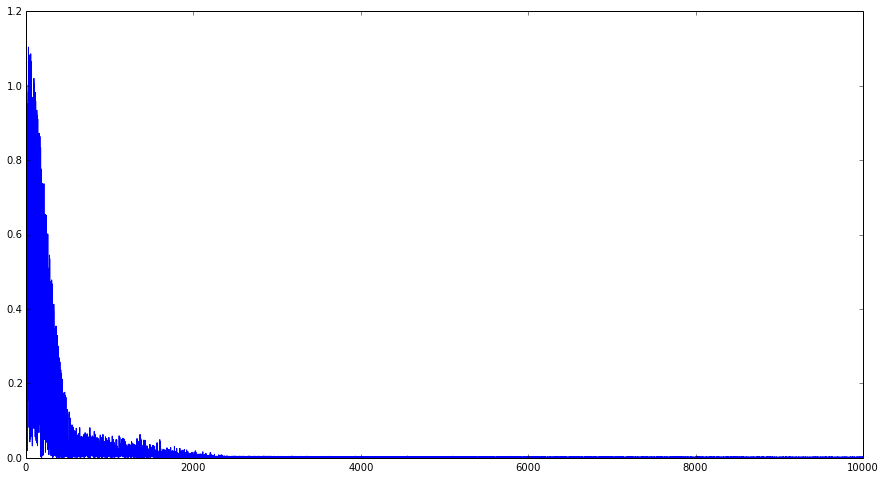

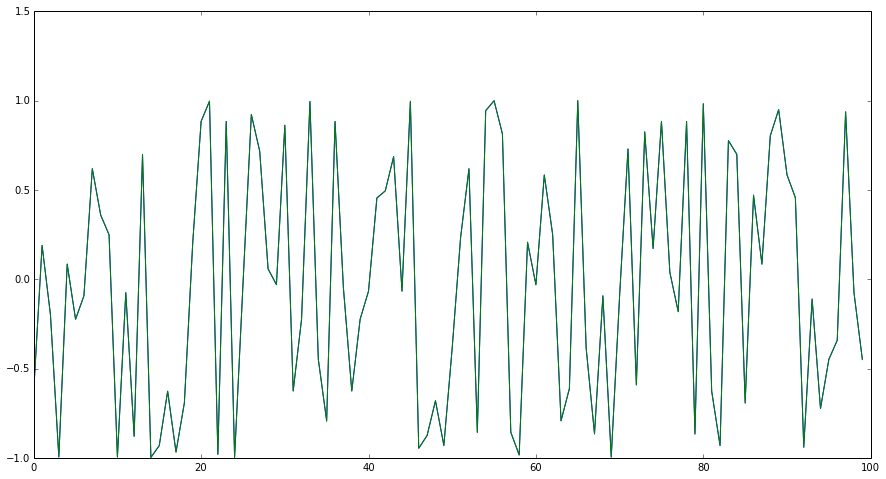

In [48]:
#plot out the entropy cause it looks cool
plt.rcParams['figure.figsize'] = (15, 8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(lossArray)  # blue
# ax1.plot(pres[len(pres) - 200:],linestyle='-',marker='o')  # green


#plot out the entropy cause it looks cool
plt.rcParams['figure.figsize'] = (15, 8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(acts[len(acts)-100:])  # blue
ax1.plot(pres[len(pres)-100:])  # green

print('average loss: {:.4f}'.format(np.mean(lossArray)))